In [15]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, DBSCAN
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

In [16]:
# Only run this if you don't have a real CSV
np.random.seed(42)
customers = [f"C{str(i).zfill(3)}" for i in range(1,201)]
dates = [datetime.today() - timedelta(days=int(x))
         for x in np.random.exponential(scale=180, size=1000)]
amounts = np.round(np.random.exponential(scale=100, size=1000),2)
df = pd.DataFrame({
    'CustomerID': np.random.choice(customers, size=1000),
    'InvoiceDate': dates,
    'InvoiceNo': np.arange(1000),
    'Amount': amounts
})
df.to_csv('synthetic_sales.csv', index=False)
print("Written synthetic_sales.csv")

Written synthetic_sales.csv


In [17]:
# If you ran Cell 2, use that file; otherwise point to your own CSV
df = pd.read_csv('synthetic_sales.csv', parse_dates=['InvoiceDate'])
# df = pd.read_csv('your_real_file.csv', parse_dates=['InvoiceDate'])
df.head()

,CustomerID,InvoiceDate,InvoiceNo,Amount
0,C135,2025-01-27 20:13:39.361657,0,20.47
1,C163,2023-10-28 20:13:39.361687,1,78.07
2,C183,2024-08-27 20:13:39.361693,2,206.31
3,C014,2024-11-08 20:13:39.361697,3,131.76
4,C120,2025-03-22 20:13:39.361701,4,164.28


In [18]:
df = df[df['CustomerID'].notna()]
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   CustomerID   1000 non-null   object        
 1   InvoiceDate  1000 non-null   datetime64[ns]
 2   InvoiceNo    1000 non-null   int64         
 3   Amount       1000 non-null   float64       
dtypes: datetime64[ns](1), float64(1), int64(1), object(1)
memory usage: 31.4+ KB


In [19]:
today = df['InvoiceDate'].max() + timedelta(days=1)

rfm = df.groupby('CustomerID').agg({
    'InvoiceDate': lambda dates: (today - dates.max()).days,
    'InvoiceNo': 'nunique',
    'Amount': 'sum'
}).rename(columns={
    'InvoiceDate': 'Recency',
    'InvoiceNo': 'Frequency',
    'Amount': 'Monetary'
})

rfm.head()

,Recency,Frequency,Monetary
CustomerID,,,
C001,16,5,891.31
C002,13,5,373.07
C003,48,3,277.45
C004,18,8,1215.85
C005,71,3,694.69


In [20]:
scaler = StandardScaler()
X = scaler.fit_transform(rfm[['Recency','Frequency','Monetary']])

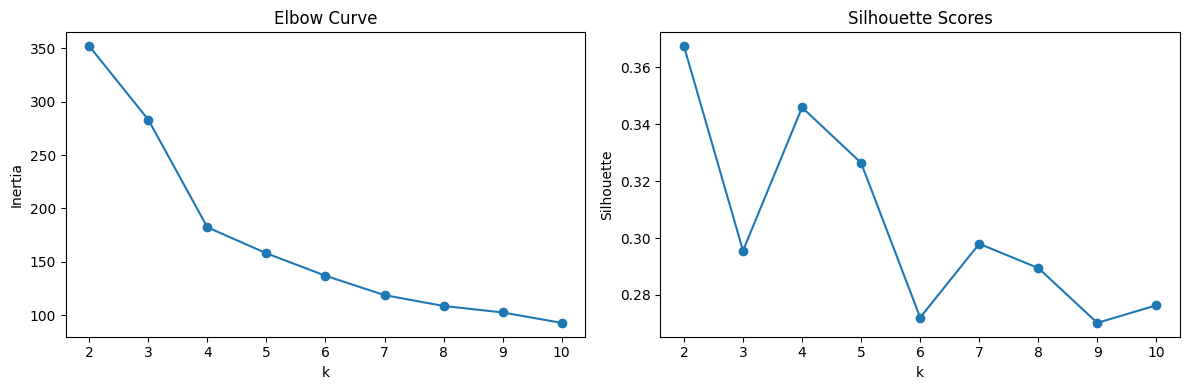

In [21]:
inertias = []
silhouettes = []
K_range = range(2, 11)

for k in K_range:
    km = KMeans(n_clusters=k, random_state=42).fit(X)
    inertias.append(km.inertia_)
    silhouettes.append(silhouette_score(X, km.labels_))

plt.figure(figsize=(12, 4))

# Elbow curve
plt.subplot(1, 2, 1)
plt.plot(K_range, inertias, '-o')      # <- use '-' not '–'
plt.title("Elbow Curve")
plt.xlabel("k")
plt.ylabel("Inertia")

# Silhouette scores
plt.subplot(1, 2, 2)
plt.plot(K_range, silhouettes, '-o')   # <- use '-' not '–'
plt.title("Silhouette Scores")
plt.xlabel("k")
plt.ylabel("Silhouette")

plt.tight_layout()
plt.show()


In [22]:
best_k = 4  # replace with your choice from Cell 7
km = KMeans(n_clusters=best_k, random_state=42).fit(X)
rfm['Cluster'] = km.labels_

In [23]:
# from sklearn.neighbors import NearestNeighbors
# neigh = NearestNeighbors(n_neighbors=5).fit(X)
# dists = np.sort(neigh.kneighbors(X)[0][:,4])
# plt.plot(dists); plt.title("5‑NN Distance Plot"); plt.show()

# Then pick eps from the “knee” and:
# db = DBSCAN(eps=0.5, min_samples=5).fit(X)
# rfm['Cluster'] = db.labels_

In [24]:
score = silhouette_score(X, rfm['Cluster'])
print(f"Average silhouette score: {score:.3f}")

Average silhouette score: 0.346


In [25]:
profile = rfm.groupby('Cluster').agg({
    'Recency':'median',
    'Frequency':'median',
    'Monetary':'median',
    'Cluster':'count'
}).rename(columns={'Cluster':'Count'})

print(profile)

         Recency  Frequency  Monetary  Count
Cluster                                     
0           16.5        6.0   586.985     74
1           30.5        3.0   294.420     84
2           15.0        8.0  1115.240     24
3          162.0        2.0   208.000     17


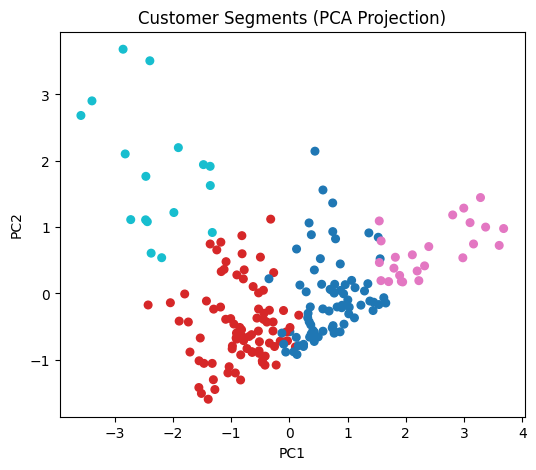

In [26]:
coords = PCA(n_components=2).fit_transform(X)
plt.figure(figsize=(6,5))
plt.scatter(coords[:,0], coords[:,1],
            c=rfm['Cluster'], cmap='tab10', s=30)
plt.title("Customer Segments (PCA Projection)")
plt.xlabel("PC1"); plt.ylabel("PC2")
plt.show()

In [27]:
rfm.reset_index().to_csv('customer_segments.csv', index=False)
print("Segments exported to customer_segments.csv")

Segments exported to customer_segments.csv
